# 목표
사용자 탐색

In [49]:
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 한글 폰트 설정
# print(matplotlib.__file__)
import subprocess

mpl_file = matplotlib.__file__
mpl_file_loc = '/'.join(mpl_file.split('/')[:-1]) + '/mpl-data/fonts/ttf/'

# 폰트 복사

subprocess.run(f'cp /usr/share/fonts/truetype/nanum/Nanum* {mpl_file_loc}', shell=True)
print(mpl_file_loc)
subprocess.run('rm -rf ~/.cache/matplotlib/*', shell=True)
plt.rcParams["font.family"] = 'NanumGothic'
matplotlib.rcParams['axes.unicode_minus'] = False  # 마이너스 폰트 깨짐 방지
# 커널 재시작

/home/innovation/codessey/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/


In [50]:
class MovieDataLoader:
    def __init__(self, file_path = '../data'):
        self.file_path = file_path
        self.__load_data()

    def __load_data(self):
        for file_name in os.listdir(self.file_path):
            self.file_name = []
            if file_name.endswith('.csv'):
                setattr(self, os.path.splitext(file_name)[0], pd.read_csv(os.path.join(self.file_path, file_name)))
            if file_name.endswith('.txt'):
                setattr(self, os.path.splitext(file_name)[0], pd.read_csv(os.path.join(self.file_path, file_name), sep='\t', engine='python'))



In [51]:
movie_data_loader = MovieDataLoader()
casting = movie_data_loader.castings
countries = movie_data_loader.countries
genres = movie_data_loader.genres
movies = movie_data_loader.movies
peoples = movie_data_loader.peoples
rates = movie_data_loader.rates

outlier_min: -0.5, outlier_max: 3.5
over 10 rate movie ratio: 3.68%


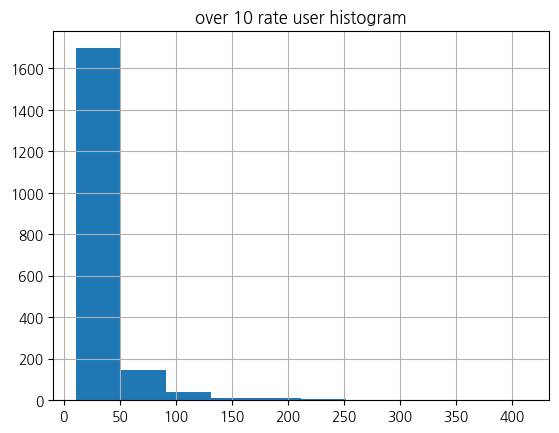

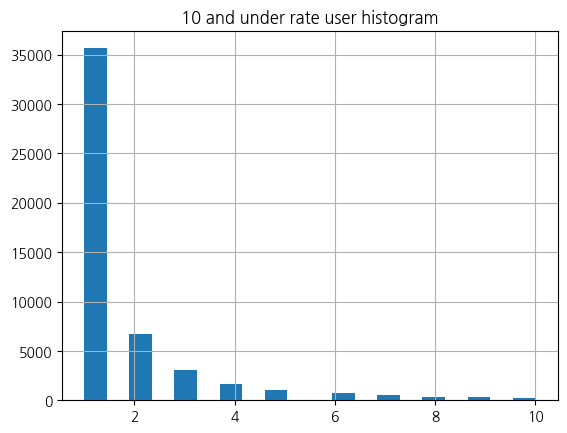

In [70]:
# 사용자별 몇 편의 영화에 평점을 남겼는지

rate_count = rates.groupby('user')['movie'].count().to_frame()
rate_count.columns = ['rate_count']
rate_count['rate_count'].describe()


# outlier using IQR method
q1 = rate_count['rate_count'].quantile(0.25)
q3 = rate_count['rate_count'].quantile(0.75)
iqr = q3 - q1
outlier_min = q1 - 1.5 * iqr
outlier_max = q3 + 1.5 * iqr

print(f'outlier_min: {outlier_min}, outlier_max: {outlier_max}')

# # ouliner using Domain knowledge
outlier_max = 10
print(f'over 10 rate movie ratio: {rate_count[rate_count["rate_count"] > outlier_max].shape[0] / rate_count.shape[0] * 100:.2f}%')

# 평점을 많이 남긴 사용자의 영화 데이터만 추출
over_10_rate_user = rate_count[rate_count['rate_count'] > outlier_max]
under_10_rate_user = rate_count[rate_count['rate_count'] <= outlier_max]
over_10_rate_user.sort_values(by='rate_count', ascending=False).head(10)

plt.title("over 10 rate user histogram")
plt.hist(over_10_rate_user['rate_count'], bins=10)
plt.grid()
plt.show()

plt.title("10 and under rate user histogram")
plt.hist(under_10_rate_user['rate_count'], bins=20)
plt.grid()
plt.show()

In [53]:
# 사용자의 활동 패턴 탐색

## 사용자의 평점 주기

rate_time = rates.copy()
rate_time['timestamp'] = pd.to_datetime(rate_time['time'], unit='s')

def date_interval(timestamps):
    start = min(timestamps)
    end = max(timestamps)
    return (end - start).days

def activity(count, date_interval):
    return count / date_interval if date_interval != 0 else 0

rate_time_group_by_user = rate_time.groupby('user')['timestamp'].agg({'min', 'max', 'count', date_interval})
rate_time_group_by_user['activity'] = rate_time_group_by_user.apply(lambda row: activity(row['count'], row['date_interval']), axis=1)
rate_time_group_by_user.sort_values(by='date_interval', ascending=False).head(10)

,date_interval,min,count,max,activity
user,,,,,
1272,5819,2003-12-14 15:00:00,101,2019-11-19 22:54:00,0.017357
819,5815,2003-11-24 15:00:00,194,2019-10-27 06:02:00,0.033362
7828,5809,2003-12-24 15:00:00,13,2019-11-20 02:15:00,0.002238
44,5805,2004-01-24 18:22:00,375,2019-12-16 19:51:00,0.064599
1020,5801,2003-11-22 15:00:00,36,2019-10-10 20:47:00,0.006206
1502,5779,2003-12-14 15:00:00,59,2019-10-10 15:44:00,0.010209
6233,5778,2003-11-22 15:00:00,20,2019-09-17 15:19:00,0.003461
1181,5777,2004-01-17 15:00:00,29,2019-11-11 16:55:00,0.005020
532,5773,2003-12-24 15:00:00,63,2019-10-15 11:11:00,0.010913


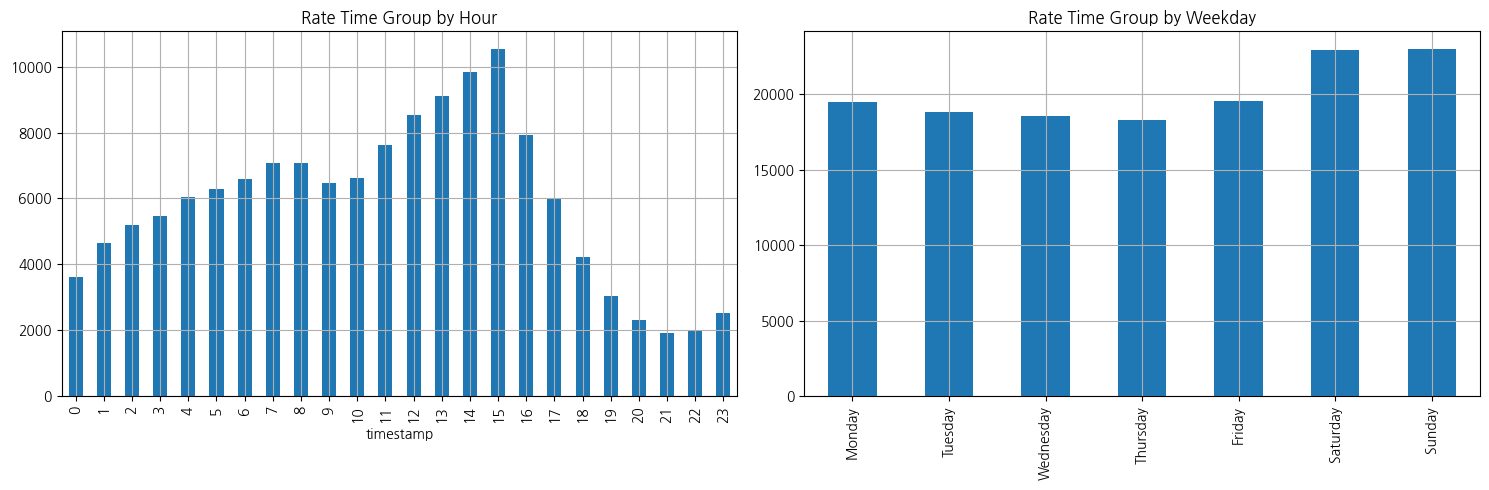

In [64]:
# 유저의 활동 패턴 탐색
## 평점을 남기는 시간대 탐색

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

rate_time_group_by_hour = rate_time['timestamp'].dt.hour.value_counts().sort_index()
rate_time_group_by_hour.plot(kind='bar', ax=axes[0])
axes[0].set_title('Rate Time Group by Hour')
axes[0].grid()

weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
rate_time_group_by_weekday = rate_time['timestamp'].dt.weekday.value_counts().sort_index()
rate_time_group_by_weekday.index = weekday_labels
rate_time_group_by_weekday.plot(kind='bar', ax=axes[1])
axes[1].set_title('Rate Time Group by Weekday')
axes[1].grid()

plt.tight_layout()
plt.show()


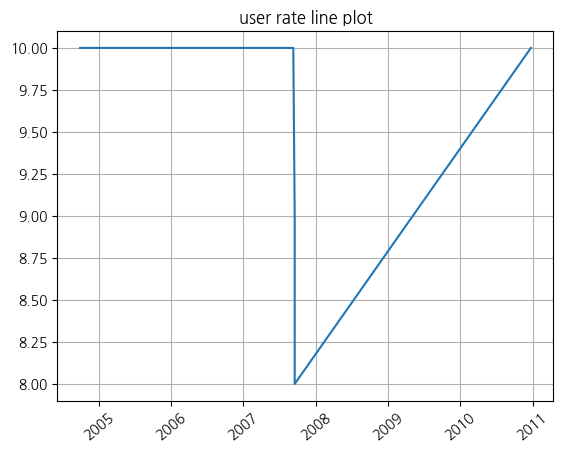

In [67]:
# 유저별 평점 분포

rates['date'] = pd.to_datetime(rates['time'], unit='s').dt.date
rates.head()
user_id = 400
user_rates = rates[rates['user'] == user_id].sort_values(by='date')
user_rates.head()

if (user_rates.shape[0] <= 1):
    print(f'user_id: {user_id} is only one rate or not exist')
else:
    plt.title("user rate line plot")
    plt.plot(user_rates['date'], user_rates['rate'],)
    plt.xticks(rotation=40)
    plt.grid()
    plt.show()

In [56]:
# 사용자 선호 (mean_rate) 장르 탐색

movies_genre = movies.merge(genres, on='movie')
movies_genre.head()
user_genre_rate = pd.crosstab(rates['user'], movies_genre['genre'], rates['rate'], aggfunc='mean').fillna(0)
user_genre_rate.head()



genre,SF,가족,공포,느와르,다큐멘터리,드라마,멜로/로맨스,모험,뮤지컬,미스터리,범죄,서부,서사,스릴러,애니메이션,액션,에로,전쟁,코미디,판타지
user,,,,,,,,,,,,,,,,,,,,
0,7.416667,7.4,10.000000,0.0,0.0,6.909091,6.666667,7.500000,0.0,0.0,7.250000,7.0,0.0,7.000000,0.0,7.625000,0.0,7.000000,7.500000,7.750000
1,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,9.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
2,10.000000,0.0,7.500000,0.0,0.0,0.000000,0.000000,9.000000,0.0,0.0,0.000000,0.0,0.0,7.400000,0.0,8.000000,0.0,0.000000,0.000000,5.000000
3,8.500000,9.0,7.555556,0.0,0.0,7.300000,5.333333,7.571429,0.0,7.0,6.250000,8.0,0.0,7.538462,0.0,7.733333,0.0,7.142857,7.333333,7.500000
4,5.500000,6.5,0.000000,0.0,0.0,6.400000,7.727273,7.250000,7.0,10.0,7.666667,0.0,0.0,7.000000,0.0,3.500000,0.0,7.500000,6.500000,7.333333


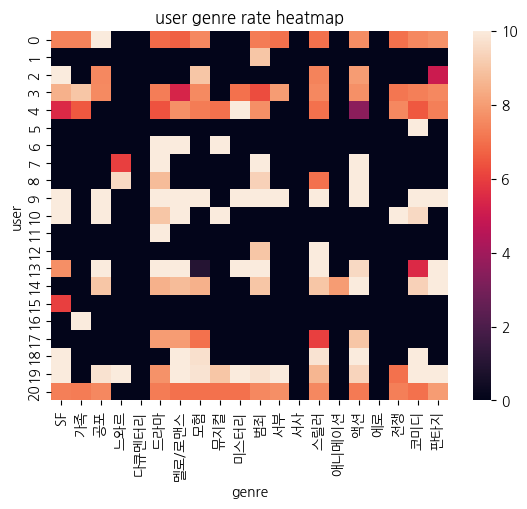

In [57]:
# visualization

user_parted = user_genre_rate[:21]

plt.title("user genre rate heatmap")
sns.heatmap(user_parted)
plt.show()


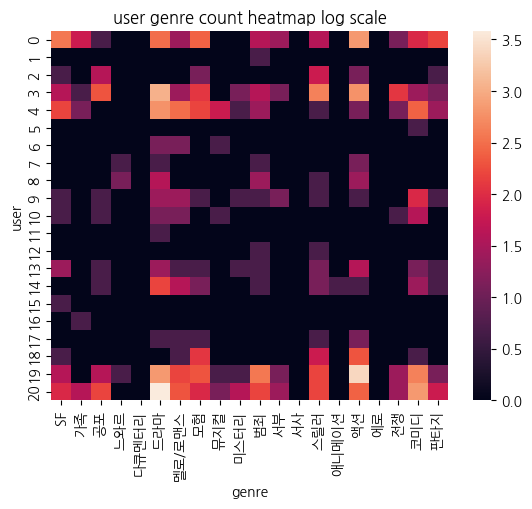

In [69]:
# user genre count visualization
user_genre_count = pd.crosstab(rates['user'], movies_genre['genre'], rates['rate'], aggfunc='count').fillna(0)
user_genre_count_parted = user_genre_count[:21]
user_genre_count_parted = user_genre_count_parted.apply(lambda x: np.log1p(x))

plt.title("user genre count heatmap log scale")
sns.heatmap(user_genre_count_parted)
plt.show()